# Data Compression with Multiple Bands

In [1]:
# imports 
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import diags, hstack as sparse_hstack
import os
from skimage.transform import resize
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import cm
from typing import List, Tuple

## Helper Functions

In [2]:
#Load in files 
def _load_nc(filepath: str):
    ds = xr.open_dataset(filepath)
    frames = ds["Rad"].values 
    times  = pd.to_datetime(ds["time"].values)
    ds.close()
    return frames, times


#Resample whilst dealing with NaNs
def _resize_nanaware(frames: np.ndarray, out_shape: Tuple[int,int], order=1) -> np.ndarray:

    T, H, W = frames.shape
    outH, outW = out_shape

    mask = np.isfinite(frames).astype(np.float32)     # valid mask
    mask_rs = np.stack([ resize(mask[t], (outH,outW), order=1, mode="edge",anti_aliasing=False, preserve_range=True)for t in range(T)], axis=0)
    
    # resize data (NaNs to 0), then renormalize by mask
    data0 = np.nan_to_num(frames, nan=0.0)
    data_rs = np.stack([resize(data0[t], (outH,outW), order=order, mode="edge", anti_aliasing=False, preserve_range=True)for t in range(T)], axis=0)
    denom = np.maximum(mask_rs, 1e-8)
    out = data_rs / denom
    out[mask_rs < 1e-8] = np.nan
    return out.astype(frames.dtype, copy=False)

def _dedup_band_times(frames, ts, how="mean"):     #Deals with frames that share the same timestamp by aggregating 

    ts = pd.to_datetime(ts)
    order = np.argsort(ts.values) #sort by time
    ts = ts[order]; frames = frames[order]

    idx = pd.Index(ts)
    if not idx.has_duplicates:
        return frames, ts

    # group indices by timestamp and aggregate
    df = pd.DataFrame({"i": np.arange(len(ts))}, index=idx)
    groups = df.groupby(level=0)["i"].apply(list)

    if how == "mean":
        agg_frames = [np.nanmean(frames[inds], axis=0) for inds in groups]
    else:
        raise ValueError("how must be one of: mean, median, last, first")

    fr_out = np.stack(agg_frames, axis=0)
    ts_out = pd.DatetimeIndex(groups.index).sort_values()

    sort_order = np.argsort(ts_out.values) #Make sure that the frames follow the same order as ts out.
    return fr_out[sort_order], ts_out.sort_values()

#Load bands and align them by time and resolution
def load_align_resample_bands(folder: str, band_ids: List[str], tolerance: str = "10s", timeline_strategy: str = "union", target_grid: str = "coarsest", resize_order: int = 1,) -> Tuple[np.ndarray, List[pd.Timestamp], List[str]]:
    #Timeline strategy can be intersection or union
    # you can choose what target grid you want to sample at as bands are different resolutions
    
    # Resolve file paths
    paths, bands = {}, []
    for bid in band_ids:
        key = bid if bid.startswith("C") else f"C{int(bid):02d}"
        fp = os.path.join(folder, f"{key}_time_series.nc")
        if not os.path.exists(fp):
            raise FileNotFoundError(f"Missing file: {fp}")
        paths[key] = fp
        bands.append(key)

    # Load all bands
    raw, shapes = [], []
    print("Loading bands...")
    for key in tqdm(bands, desc="Loading", total=len(bands)):
        fr, ts = _load_nc(paths[key]) #get keys
        raw.append((key, fr, ts))
        shapes.append(fr.shape[1:])

    # Choose target grid from band resolutions
    if isinstance(target_grid, str) and target_grid.lower() in ("coarsest","finest"):
        areas = [h*w for (h,w) in shapes]
        idx = np.argmin(areas) if target_grid.lower()=="coarsest" else np.argmax(areas)
        target_H, target_W = shapes[idx]
        target_band = raw[idx][0]
    else:
        key = target_grid if str(target_grid).startswith("C") else f"C{int(target_grid):02d}"
        match = [i for i,(k,_,_) in enumerate(raw) if k==key]
        if not match:
            raise ValueError(f"target_grid band {key} not in selection {bands}")
        target_H, target_W = raw[match[0]][1].shape[1:]
        target_band = key
    print(f"Target grid: {target_band} → ({target_H}, {target_W})")

    # Resample bands to target grid
    resampled_frames, times_list = [], []
    print("Resampling to common grid.")
    for key, fr, ts in tqdm(raw, desc="Resampling", total=len(raw)):
        if fr.shape[1:] == (target_H, target_W):
            fr_out = fr
        else:
            fr_out = _resize_nanaware(fr, (target_H, target_W), order=resize_order)
    
        #make sure bands dont have duplicated times
        fr_out, ts_out = _dedup_band_times(fr_out, ts, how="mean")
    
        resampled_frames.append(fr_out) #get frames with resampled times
        times_list.append(ts_out)
        
    # Build aligned timeseries with equal spacing
    if timeline_strategy == "union":
        all_times = sorted(set().union(*[set(t) for t in times_list]))
        target_times = pd.DatetimeIndex(all_times)
    elif timeline_strategy == "intersection":
        common = set(times_list[0])
        for t in times_list[1:]:
            common &= set(t)
        target_times = pd.DatetimeIndex(sorted(common))
    else:
        raise ValueError("timeline_strategy must be 'union' or 'intersection'")

    # Align each band to the target timeline (nearest within tolerance) and fill missing times with NaNs
    print("Aligning timelines.")
    aligned = []
    H, W = target_H, target_W
    for frames, ts in tqdm(zip(resampled_frames, times_list), total=len(resampled_frames), desc="Aligning"):
        
        
        s = (pd.Series(np.arange(len(ts)), index=pd.DatetimeIndex(ts)).sort_index())
        
        # Drop any residual duplicates
        s = s[~s.index.duplicated(keep="first")]
        idx = s.reindex(pd.DatetimeIndex(target_times),method="nearest", tolerance=tolerance)
        vals = idx.values  # may contain NaN and float dtype
        out = np.empty((len(target_times), H, W), dtype=frames.dtype)

        nan_frame = np.full((H, W), np.nan, dtype=frames.dtype)
        is_nan = pd.isna(vals)

        # fill NaN positions with nan_frame
        out[is_nan, :, :] = nan_frame

        # fill valid positions using integer indices
        if (~is_nan).any():
            good = vals[~is_nan].astype(int)
            out[~is_nan, :, :] = frames[good, :, :]

        aligned.append(out)

    X = np.stack(aligned, axis=1)  #(T_common, B, H_out, W_out)
    return X, list(target_times.to_pydatetime()), bands

# Aggregate timestamps to ensure there are no duplicates
def coalesce_duplicate_timestamps_xr(X, times, how="mean"): #this could be changed to median, max or min as well. 
    times = pd.to_datetime(times)
    da = xr.DataArray( X, dims=("time","band","y","x"),coords={"time": times, "band": np.arange(X.shape[1]),"y": np.arange(X.shape[2]), "x": np.arange(X.shape[3])} )
    if how == "mean":
        da2 = da.groupby("time").mean("time", skipna=True)
    elif how == "median":
        da2 = da.groupby("time").median("time", skipna=True)
    elif how == "max":
        da2 = da.groupby("time").max("time", skipna=True)
    elif how == "min":
        da2 = da.groupby("time").min("time", skipna=True)
    else:
        raise ValueError("how must be one of: mean, median, max, min")

    X_out = da2.data
    t_out = pd.to_datetime(da2["time"].values)
    return X_out, t_out

In [3]:
#Scales min and max values 
def _percentile_scale(x, lo=2, hi=98):
    vmin = np.nanpercentile(x, lo); vmax = np.nanpercentile(x, hi)
    if not np.isfinite(vmin): vmin = np.nanmin(x)
    if not np.isfinite(vmax): vmax = np.nanmax(x)
    if vmax <= vmin: vmax = vmin + 1e-6
    return vmin, vmax

def _to01(x, vmin, vmax): #normalize x for plotting. 
    return np.clip((x - vmin) / (vmax - vmin + 1e-8), 0, 1)

# Plot time series, per band, as well as a a single combined curve
def plot_stacked_time_series(X,times=None, row=None, col=None,band_labels=None,show_pca=False,normalize=False,title=None,):
    #make sure right dimensions
    assert X.ndim == 4, "X must be (T,B,H,W)"
    
    T, B, H, W = X.shape
    if row is None: row = H // 2
    if col is None: col = W // 2

    # Extract per-band curves at the center pixel
    Y = X[:, :, row, col] 

    # Build x-axis
    x = np.arange(T) if (times is None or len(times) != T) else times

    # Optional per-band normalization just for display
    Y_plot = Y.copy().astype(float)
    if normalize:
        for b in range(B):
            mu = np.nanmean(Y_plot[:, b])
            sd = np.nanstd(Y_plot[:, b]) + 1e-8
            Y_plot[:, b] = (Y_plot[:, b] - mu) / sd

    # Plot
    plt.figure(figsize=(9, 4))
    for b in range(B):
        lbl = band_labels[b] if (band_labels and b < len(band_labels)) else f"Band {b+1}"
        plt.plot(x, Y_plot[:, b], label=lbl, linewidth=1.5, alpha = 0.5)

    # Optional combined curve (computed across bands for this pixel via PCA)
    if show_pca:
        # center across bands, then project onto first PC
        Yc = Y - np.nanmean(Y, axis=0, keepdims=True)
        # handle NaNs safely
        Yc = np.nan_to_num(Yc, nan=0.0)
        # PCA on B-dim features across time T
        # If T < B, SVD still works and gives principal time-direction
        U, S, Vt = np.linalg.svd(Yc, full_matrices=False)
        pc1 = U[:, 0] * S[0]  # principal temporal component
        # normalize for plotting scale
        pc1 = pc1 / (np.std(pc1) + 1e-8)
        plt.plot(x, pc1, 'k--', linewidth=2.0, label='Combined Time Series')

    plt.grid(True, alpha=0.3)
    plt.xlabel("Time")
    ylabel = "Radiance (normalized)" if normalize else "Value"
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    else:
        plt.title(f"Pixel time series at (row={row}, col={col})")
    plt.legend(ncol=min(B+1, 5), fontsize=8)
    plt.tight_layout()
    plt.show()

### Run Functions to Stack Bands

Loading bands...


Loading: 100%|████████████████████████████████████| 5/5 [00:17<00:00,  3.47s/it]


Target grid: C13 → (50, 50)
Resampling to common grid...


Resampling: 100%|█████████████████████████████████| 5/5 [00:11<00:00,  2.22s/it]


Aligning timelines...


Aligning: 100%|███████████████████████████████████| 5/5 [00:00<00:00, 29.61it/s]


Stack: (14394, 5, 50, 50) Bands: ['C01', 'C02', 'C03', 'C13', 'C15'] Frames: 14394
Stack: (14394, 5, 50, 50) Bands: ['C01', 'C02', 'C03', 'C13', 'C15'] Frames: 14394


Rendering frames:   0%|                               | 0/14394 [00:00<?, ?it/s]/var/folders/sz/vyxqp2d96dd_9nf4jdvs29800000gn/T/ipykernel_12576/1475367632.py:57: RuntimeWarning: invalid value encountered in cast
  frames_rgb.append((img*255).astype(np.uint8))
Rendering frames: 100%|████████████████| 14394/14394 [00:00<00:00, 16040.89it/s]


Saved animation with 14394 frames to before_pca.gif


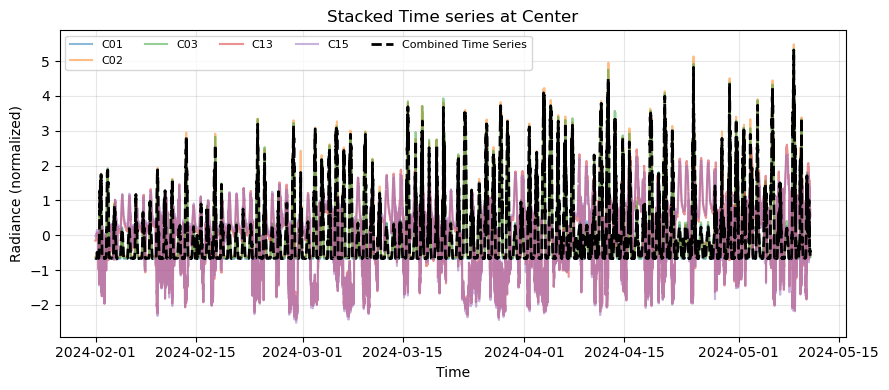

Rendering true-color frames:   0%|                    | 0/14394 [00:00<?, ?it/s]/var/folders/sz/vyxqp2d96dd_9nf4jdvs29800000gn/T/ipykernel_12576/1475367632.py:149: RuntimeWarning: invalid value encountered in cast
  frames.append((np.clip(rgb,0,1)*255).astype(np.uint8))
Rendering true-color frames: 100%|█████| 14394/14394 [00:01<00:00, 12169.76it/s]


In [4]:
#Parameters
folder = "time_series_cleaned_bos"
band_ids = ["C01","C02","C03","C13","C15"]

X, times, bands = load_align_resample_bands(folder, band_ids, tolerance="10s", timeline_strategy="union",target_grid="coarsest",resize_order=1)
X, times = coalesce_duplicate_timestamps_xr(X, times, how="mean")
print("Stack:", X.shape, "Bands:", bands, "Frames:", len(times))

# Plot stacked time series at the center pixel 
H, W = X.shape[2], X.shape[3]
plot_stacked_time_series(X, times, row=H//2, col=W//2, band_labels=bands, show_pca=True, normalize=True,title="Stacked Time series at Center")


# Compress bands 

In [5]:
# Compression function similar to the single band compression but now for multiple bands! 
def compress_stacked_bands_by_time(X,times,duration: timedelta,p: float = 0.5,noise_std: float = 0.0,seed: int | None = None,build_sparse_ops: bool = False,):
    assert X.ndim == 4, "X must be (T,B,H,W)"
    T, B, H, W = X.shape
    rng = np.random.default_rng(seed)

    compressed_list = []
    blocks_list = []
    masks_list = []
    counts_list = []
    block_times = []

    y_big, phi_big, x_big, g_big = [], [], [], [] # Optional forward-model containers per band

    start_idx = 0
    with tqdm(desc="Compressing stacked bands") as pbar:
        while start_idx < T:
            t0 = times[start_idx]
            end_idx = start_idx
            while end_idx < T and (times[end_idx] - t0) < duration:
                end_idx += 1

            window = X[start_idx:end_idx]  
            n_t = window.shape[0]
            if n_t == 0:
                break

            block_times.append(t0 + (duration/2))

            # masks per band
            m = (rng.random((B, n_t, H, W)) < p).astype(np.float32)

            #Make sure that the center pixel sampled at least once per band
            for b in range(B):
                if m[b, :, H//2, W//2].sum() == 0:
                    m[b, rng.integers(0, n_t), H//2, W//2] = 1

            # masked sums, counts, forward-average
            Y_block = np.empty((B, H, W), dtype=np.float32)
            C_block = np.empty((B, H, W), dtype=np.float32)
            F_block = np.empty((B, H, W), dtype=np.float32)

            # Optional: forward-model pieces per band
            if build_sparse_ops:
                y_band_list, phi_band_list, x_band_list, g_band_list = [], [], [], []

            for b in range(B):
                # masked sum over time
                masked_sum = np.nansum(window[:, b] * m[b], axis=0)  # (H,W)
                count = np.sum(m[b], axis=0)                         # (H,W)

                if noise_std > 0:
                    masked_sum = masked_sum + rng.normal(0, noise_std, size=(H, W)).astype(np.float32)

                Y_block[b] = masked_sum
                C_block[b] = count
                F = masked_sum / np.maximum(count, 1e-8)
                F[count == 0] = np.nan
                F_block[b] = F

                if build_sparse_ops:
                    # Flatten ground-truth x for this band and build block-diagonal Phi
                    x_b = np.concatenate([frame.flatten() for frame in window[:, b]])
                    diagonal_masks = [diags(mask.flatten(), 0, format='csr') for mask in m[b]]
                    Phi_b = sparse_hstack(diagonal_masks).tocsr()
                    g_b = 0.0
                    y_b = Phi_b @ x_b + g_b

                    y_band_list.append(y_b)
                    phi_band_list.append(Phi_b)
                    x_band_list.append(x_b)
                    g_band_list.append(g_b)

            compressed_list.append(F_block)                          
            counts_list.append(C_block)                              
            blocks_list.append(np.transpose(window, (1, 0, 2, 3)))   
            masks_list.append(m)                                   

            if build_sparse_ops:
                y_big.append(y_band_list)
                phi_big.append(phi_band_list)
                x_big.append(x_band_list)
                g_big.append(g_band_list)

            pbar.update(n_t)
            start_idx = end_idx

    Wn = len(compressed_list)
    merged_block_times = [times[0] + i*duration for i in range(Wn)]

    out = {"compressed": np.stack(compressed_list, axis=0),"blocks":blocks_list,"masks": masks_list,"counts":np.stack(counts_list, axis=0),"block_times": block_times, "merged_block_times": merged_block_times,}
    if build_sparse_ops:
        out.update({"y_list":  y_big,"phi_list":phi_big,"x_list":  x_big,"g_list":  g_big,})
    return out

#save compressed blocks
def save_compressed_blocks_multiband(comp,out_dir,location,band_ids,save_masks=True,save_blocks=False,masks_dtype=np.uint8,counts_dtype=np.uint16, y_dtype=np.float32,):
    os.makedirs(out_dir, exist_ok=True)

    if "compressed" not in comp:
        raise KeyError("comp['compressed'] is required")

    Y = np.asarray(comp["compressed"])
    if Y.ndim != 4: #make sure right dimensions
        raise ValueError(f"comp['compressed'] must be (Wn,B,H,W), got {Y.shape}")
    Wn, B, H, W = Y.shape

    # band_ids (avoid object dtype)
    band_ids_arr = np.array(list(map(str, band_ids)), dtype="U16")

    # Optional components
    has_counts = "counts" in comp and comp["counts"] is not None
    has_masks  = "masks"  in comp and comp["masks"]  is not None
    has_blocks = "blocks" in comp and comp["blocks"] is not None

    # Handle time metadata
    tt_per_block = comp.get("target_times_per_block", None) # We want target_times_per_block as list of arrays
    tt_matrix    = comp.get("target_times", None)

    # Helper to get per-k target_times array (or None)
    def get_target_times_for_k(k, T_hint=None):
        if tt_per_block is not None:
            tt_k = tt_per_block[k]
            return np.asarray(tt_k, dtype="datetime64[ns]")
        if tt_matrix is not None:
            tt = np.asarray(tt_matrix)
            # support list-of-arrays or matrix
            if isinstance(tt_matrix, (list, tuple)):
                return np.asarray(tt_matrix[k], dtype="datetime64[ns]")
            if tt.ndim == 2:  # (Wn, T)
                return tt[k].astype("datetime64[ns]")
        if has_masks:
            # Make a synthetic evenly spaced index if masks provide T
            mk = comp["masks"][k]
            T = mk.shape[1] if mk.ndim == 4 else mk.shape[0]  # try to infer dimensions
            if T_hint is not None:
                T = T_hint
            # No real timestamps then omit
            return None
        return None

    #Counts array to see sampling distribution
    if has_counts:
        C = np.asarray(comp["counts"])
        if C.shape != (Wn, B, H, W):
            raise ValueError(f"counts shape {C.shape} != (Wn,B,H,W) {(Wn,B,H,W)}")
        C = C.astype(counts_dtype, copy=False)

    #Get masks
    def get_masks_k(k):
        if not has_masks: return None
        mk = comp["masks"][k]
        mk = np.asarray(mk)
        #make sure dimensions are right 
        if mk.ndim == 4 and mk.shape[0] != B and mk.shape[1] == B:
            mk = mk.transpose(1,0,2,3)
        return (mk > 0).astype(masks_dtype, copy=False)

    def get_blocks_k(k):
        if not has_blocks: return None
        bk = np.asarray(comp["blocks"][k], dtype=x_dtype)
        #Makesure dimensions are right
        if bk.ndim == 4 and bk.shape[0] != B and bk.shape[1] == B:
            bk = bk.transpose(1,0,2,3)
        return bk

    # Block times 
    block_times = comp.get("block_times", None)

    for k in range(Wn):
        y  = np.asarray(Y[k], dtype=y_dtype)
        payload = {"compressed": y,"band_ids":   band_ids_arr,}
        if block_times is not None:
            payload["block_time"] = str(block_times[k])

        # counts
        if has_counts:
            payload["counts"] = C[k]                  

        # masks
        mk = get_masks_k(k)
        if mk is not None:
            payload["masks"] = mk                     
            T_hint = mk.shape[1]
        else:
            T_hint = None

        # blocks (ground truth)
        bk = get_blocks_k(k)
        if bk is not None and save_blocks:
            payload["blocks"] = bk                  

        # target_times (best-effort)
        tt_k = get_target_times_for_k(k, T_hint=T_hint)
        if tt_k is not None:
            payload["target_times"] = tt_k

        out_fp = os.path.join(out_dir, f"{location}_block_{k:03d}.npz")
        np.savez_compressed(out_fp, **payload)

    print(f"Saved {Wn} compressed blocks for {location} → {out_dir}")
    return out_dir

In [6]:
#Show per band panels for each compressed block
def show_compressed_block_bands(comp, band_ids, k=0, cmap="gray"):
    Xc = comp["compressed"]     
    Wn, B, H, W = Xc.shape
    k = int(np.clip(k, 0, Wn-1))

    # global per-band scales across all compressed windows
    vmins, vmaxs = [], []
    for b in range(B):
        vals = Xc[:, b].ravel()
        vmin = np.nanpercentile(vals, 2)
        vmax = np.nanpercentile(vals, 98)
        if not np.isfinite(vmin): vmin = np.nanmin(vals)
        if not np.isfinite(vmax): vmax = np.nanmax(vals)
        if vmax <= vmin: vmax = vmin + 1e-6
        vmins.append(vmin); vmaxs.append(vmax)

    fig, axes = plt.subplots(1, B, figsize=(3.4*B, 3.2))
    if B == 1: axes = [axes]
    for b, ax in enumerate(axes):
        im = ax.imshow(Xc[k, b], cmap=cmap, vmin=vmins[b], vmax=vmaxs[b])
        ax.set_title(band_ids[b])
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    tlabel = str(comp["block_times"][k]) if "block_times" in comp else f"block {k}"
    fig.suptitle(f"Compressed block {k}  •  {tlabel}")
    plt.tight_layout(); plt.show()

#Plot center-pixel time series from compressed blocks
def plot_compressed_pixel_series(comp, band_ids, row=None, col=None, normalize=True, title=None):
    Xc = comp["compressed"]     # (Wn,B,H,W)
    Wn, B, H, W = Xc.shape
    if row is None: row = H//2
    if col is None: col = W//2

    Y = Xc[:, :, row, col]      # (Wn,B)
    t = comp.get("block_times", np.arange(Wn))

    Yp = Y.astype(float).copy()
    if normalize:
        for b in range(B):
            mu = np.nanmean(Yp[:, b])
            sd = np.nanstd(Yp[:, b]) + 1e-8
            Yp[:, b] = (Yp[:, b] - mu) / sd

            
    # Make figure
    plt.figure(figsize=(9,4))
    for b in range(B):
        plt.plot(t, Yp[:, b], label=band_ids[b], lw=1.5)
    plt.grid(True, alpha=0.3)
    plt.xlabel("Block time")
    plt.ylabel("Radiance (Normalized)" if normalize else "Value")
    plt.title(title or f"Compressed Time series at Centre Pixel")
    plt.legend(ncol=min(B,5), fontsize=8)
    plt.tight_layout(); plt.show()

Compressing stacked bands: 14394it [00:01, 10904.07it/s]
Rendering frames: 100%|████████████████████| 200/200 [00:00<00:00, 18703.28it/s]


Saved animation with 200 frames to compressed_pca.gif
Saved 200 compressed blocks for bos → compressed_blocks_bos


Rendering compressed PCA: 100%|████████████| 200/200 [00:00<00:00, 13802.73it/s]

Saved compressed PCA GIF to bos_compressed_pca.gif


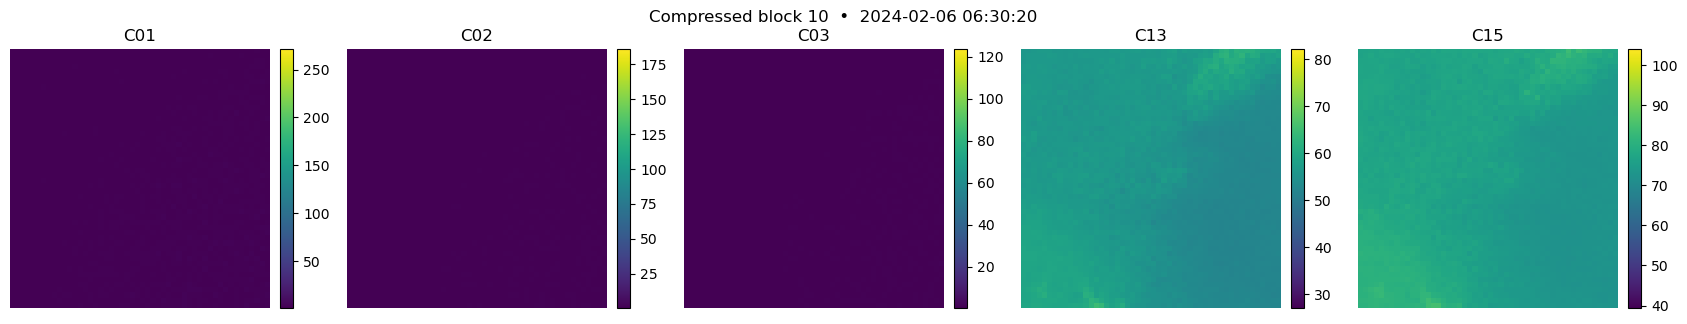

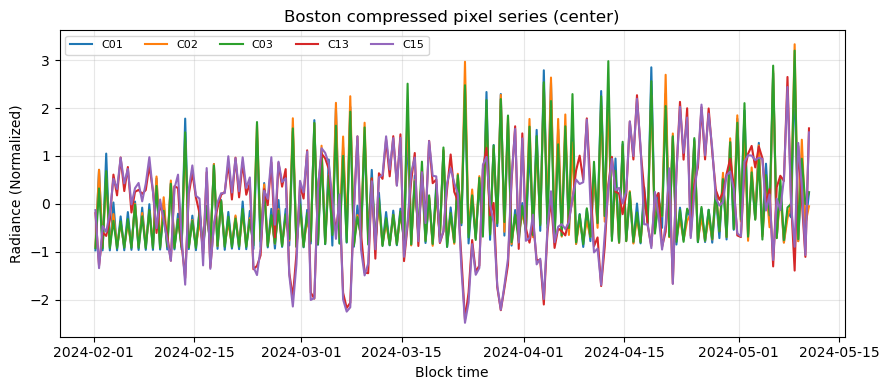

In [7]:
#Run Functions 

#EXAMPLE: BOSTON
duration = timedelta(hours=12)

comp = compress_stacked_bands_by_time(X, times, duration=duration, p=0.5, seed=42,build_sparse_ops=False)
save_compressed_blocks_multiband(comp, out_dir="compressed_blocks_bos",location="bos",band_ids=bands)

Panel view of a specific compressed block (e.g., the 10th)
show_compressed_block_bands(comp, band_ids=bands, k=10, cmap="viridis")

#Center-pixel compressed time series
H, W = comp["compressed"].shape[2:]
plot_compressed_pixel_series(comp, band_ids=bands, row=H//2, col=W//2,
                             normalize=True, title="Boston compressed pixel series (center)")

In [8]:
#Make per block equal length tensors (so all blocks will be the same number of frames)
def regularize_into_equal_blocks(X, times,duration: timedelta,frame_spacing: timedelta, max_gap: timedelta):
   
    assert X.ndim == 4, "X must be (T,B,H,W)" #Check dimensions
    T, B, H, W = X.shape
    times = pd.to_datetime(times)
    
    # precompute constants
    n_t = int(round(duration / frame_spacing))
    if n_t <= 0:
        raise ValueError("duration/frame_spacing must yield n_t >= 1")

    #Build a DataArray using Xarray to interpolate along time cleanly
    da = xr.DataArray(X, dims=("time","band","y","x"),coords={"time": times, "band": np.arange(B), "y": np.arange(H), "x": np.arange(W)})

    blocks_equal = []
    target_times_per_block = []
    block_times = []

    # sweep windows of ideal duration
    start_idx = 0
    with tqdm(desc="Regularizing into equal-length blocks") as pbar:
        while start_idx < T:
            t0 = times[start_idx]
            # end
            t1 = t0 + duration
            # select source slice with a small margin so that interpolation at edges has neighbors
            src = da.sel(time=slice(t0 - frame_spacing, t1 + frame_spacing))

            # build the target regular grid for THIS block
            tgt_times = pd.date_range(t0, periods=n_t, freq=pd.to_timedelta(frame_spacing))

            if src.sizes.get("time", 0) == 0:
                # no data in this window; make an all-NaN block
                blk = np.full((n_t, B, H, W), np.nan, dtype=X.dtype)
                blocks_equal.append(blk)
                target_times_per_block.append(list(tgt_times.to_pydatetime()))
                block_times.append(t0 + duration/2)
                # advance start_idx to first time >= t1
                start_idx = int(np.searchsorted(times.values, np.datetime64(t1)))
                pbar.update(max(1, start_idx))
                continue

            # interpolate linearly along time
            interp = src.interp(time=tgt_times, kwargs={"fill_value": None})  # linear; NaN outside range

            # now we will find the nearest real source sample distance for each target time
            nearest_idx = src.indexes["time"].get_indexer(tgt_times, method="nearest", tolerance=max_gap)
            bad = (nearest_idx == -1) # If nearest_idx == -1 it means no sample within tolerance
            if bad.any():
                interp.data[bad, ...] = np.nan

            
            blk = interp.data.astype(X.dtype, copy=False)
            blocks_equal.append(blk)
            target_times_per_block.append(list(tgt_times.to_pydatetime()))
            block_times.append(t0 + duration/2)

            # advance start index to first time >= t1
            start_idx = int(np.searchsorted(times.values, np.datetime64(t1)))
            pbar.update(max(1, start_idx))

    return blocks_equal, target_times_per_block, block_times



In [9]:
#Compress blocks that are of equal cadence
def compress_locations_fixed_equalcadence(base_path,locations,band_ids,out_root,duration=timedelta(hours=12),frame_spacing=timedelta(minutes=10),max_gap=timedelta(minutes=12),tolerance="10s",timeline_strategy="union",target_grid="coarsest",resize_order=1,p=0.5,seed=42,save_counts=True,save_masks=True,save_blocks=True,store_forward_as="avg"):

    os.makedirs(out_root, exist_ok=True)
    summary = []
    rng = np.random.default_rng(seed)

    for loc in locations:
        loc_in = os.path.join(base_path, f"time_series_cleaned_{loc}")
        if not os.path.isdir(loc_in):
            print(f"[{loc}] missing {loc_in}"); summary.append((loc,0,0,"")); continue

        try:
            X, times, bands = load_align_resample_bands(loc_in, band_ids, tolerance, timeline_strategy, target_grid, resize_order)
            X, times = coalesce_duplicate_timestamps_xr(X, times, how="mean")
        except Exception as e:
            print(f"[{loc}] load/align failed: {e}"); summary.append((loc,0,0,"")); continue

        if X.shape[0] == 0:
            print(f"[{loc}] no frames"); summary.append((loc,0,0,"")); continue

        # Equal-length windows per location
        blocks_eq, tgt_times, block_times = regularize_into_equal_blocks(X, times, duration, frame_spacing, max_gap)

        out_dir = os.path.join(out_root, loc); os.makedirs(out_dir, exist_ok=True)
        band_ids_arr = np.array([str(b) for b in bands], dtype="U16")

        n_out = len(blocks_eq)
        for k, blk in enumerate(tqdm(blocks_eq, desc=f"[{loc}] saving")):
            T_blk, B, H, W = blk.shape
            X_bthw = blk.transpose(1,0,2,3).astype(np.float32, copy=False)  

            # Availability map 
            avail = np.isfinite(X_bthw)                                      
            
            # Bernoulli only where data exists
            m = ((rng.random((B, T_blk, H, W)) < p) & avail).astype(np.uint8)  
            
            # Guarantee ≥1 sample per pixel if any frame is available
            miss = (m.sum(axis=1) == 0) & (avail.any(axis=1))               
            if miss.any():
                t_mid = T_blk // 2
                # nearest available time to the middle
                dist = np.abs(np.arange(T_blk)[None, :, None, None] - t_mid)      
                dist_masked = np.where(avail, dist, np.inf)                        
                t_idx = dist_masked.argmin(axis=1).astype(np.int32)                
                b_idx, h_idx, w_idx = np.where(miss)
                t_pick = t_idx[b_idx, h_idx, w_idx]
                m[b_idx, t_pick, h_idx, w_idx] = 1
            
            # Counts and forward projection
            counts = m.sum(axis=1, dtype=np.uint16)                          
            y_sum  = np.nansum(X_bthw * m.astype(np.float32), axis=1).astype(np.float32)
            
            if store_forward_as == "avg":
                y = y_sum / np.maximum(counts.astype(np.float32), 1e-8)
                y[counts == 0] = np.nan
            elif store_forward_as == "sum":
                y = y_sum

            else:
                raise ValueError("store_forward_as must be 'avg' or 'sum'")

            payload = {"compressed": y.astype(np.float32),"band_ids":   band_ids_arr,"block_time": str(block_times[k]),"target_times": np.array(tgt_times[k], dtype="datetime64[ns]"),}
            if save_counts:
                payload["counts"] = counts                                    # [B,H,W] uint16
            if save_masks:
                payload["masks"]  = m                                         # [B,T,H,W] uint8
            if save_blocks:
                payload["blocks"] = X_bthw                                    # [B,T,H,W] float32

            np.savez_compressed(os.path.join(out_dir, f"{loc}_block_{k:03d}.npz"), **payload)

        summary.append((loc, X.shape[0], n_out, out_dir))
        print(f"[{loc}] In: {X.shape[0]} → Out: {n_out} equal-cadence blocks → {out_dir}")
        print(f"[{loc}] block lengths (frames per block): {[blk.shape[0] for blk in blocks_eq]}")

    return summary

In [10]:
locations = ['losangeles']
band_ids  = ["C01","C02","C03","C13","C15"]

summary = compress_locations_fixed_equalcadence(base_path=".",locations=locations,band_ids=band_ids,out_root="multiband_compressed_blocks_12hrs",duration=timedelta(hours=12),frame_spacing=timedelta(minutes=10),max_gap=timedelta(minutes=12),p=0.5, seed=42,save_counts=True, save_masks=True)
print(summary)


Loading bands...


Loading: 100%|████████████████████████████████████| 5/5 [00:16<00:00,  3.40s/it]


Target grid: C13 → (50, 50)
Resampling to common grid...


Resampling:   0%|                                         | 0/5 [00:00<?, ?it/s]/var/folders/sz/vyxqp2d96dd_9nf4jdvs29800000gn/T/ipykernel_12576/730099979.py:55: RuntimeWarning: Mean of empty slice
  agg_frames = [np.nanmean(frames[inds], axis=0) for inds in groups]
Resampling:  20%|██████▌                          | 1/5 [00:03<00:13,  3.29s/it]/var/folders/sz/vyxqp2d96dd_9nf4jdvs29800000gn/T/ipykernel_12576/730099979.py:55: RuntimeWarning: Mean of empty slice
  agg_frames = [np.nanmean(frames[inds], axis=0) for inds in groups]
Resampling:  40%|█████████████▏                   | 2/5 [00:08<00:13,  4.55s/it]/var/folders/sz/vyxqp2d96dd_9nf4jdvs29800000gn/T/ipykernel_12576/730099979.py:55: RuntimeWarning: Mean of empty slice
  agg_frames = [np.nanmean(frames[inds], axis=0) for inds in groups]
Resampling:  60%|███████████████████▊             | 3/5 [00:11<00:07,  3.85s/it]/var/folders/sz/vyxqp2d96dd_9nf4jdvs29800000gn/T/ipykernel_12576/730099979.py:55: RuntimeWarning: Mean of empty slice
 

Aligning timelines...


Aligning: 100%|███████████████████████████████████| 5/5 [00:00<00:00, 28.35it/s]
Regularizing into equal-length blocks: 1432750it [00:01, 1166417.32it/s]
[losangeles] saving: 100%|████████████████████| 199/199 [00:50<00:00,  3.95it/s]

[losangeles] In: 14312 → Out: 199 equal-cadence blocks → multiband_compressed_blocks_12hrs/losangeles
[losangeles] block lengths (frames per block): [72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72]
[('losangeles', 14312, 199, 'multiband_compressed_bloc

# Time series using a 1 day measurements instead of every 10 minutes

In [11]:
#Function to get the daily average frame
def daily_average_stack(X,times,min_per_day=1,full_range=False):
    assert X.ndim == 4, "X must be (T,B,H,W)"
    T,B,H,W = X.shape
    times = pd.to_datetime(times)

    # Put into xarray for easy time grouping
    da = xr.DataArray(X, dims=("time","band","y","x"),coords={"time": times, "band": np.arange(B), "y": np.arange(H), "x": np.arange(W)})

    # Group by calendar day
    grp = da.groupby('time.date')         
    daily = grp.mean('time', skipna=True) 
    counts = grp.count('time')            
    
    #Enforce a minimum number of samples per pixel/day to make sure no empty days
    if min_per_day > 1:
        daily = daily.where(counts >= min_per_day)

    # Build day_times set to midnight of each day
    day_index = pd.to_datetime(daily['date'].values)  # to pandas Timestamps at 00:00
    if full_range:
        full_days = pd.date_range(day_index.min().normalize(), day_index.max().normalize(), freq='D')
        daily = daily.reindex(date=full_days)   # missing days become NaN
        counts = counts.reindex(date=full_days)
        day_index = full_days

    X_day = daily.data.astype(X.dtype, copy=False)
    counts_day = counts.data.astype(np.int32, copy=False)
    day_times = list(day_index.to_pydatetime())
    return X_day, day_times, counts_day


Daily stack: (100, 5, 50, 50) days: 100


Rendering frames: 100%|████████████████████| 100/100 [00:00<00:00, 16163.02it/s]

Saved animation with 100 frames to daily_pca.gif


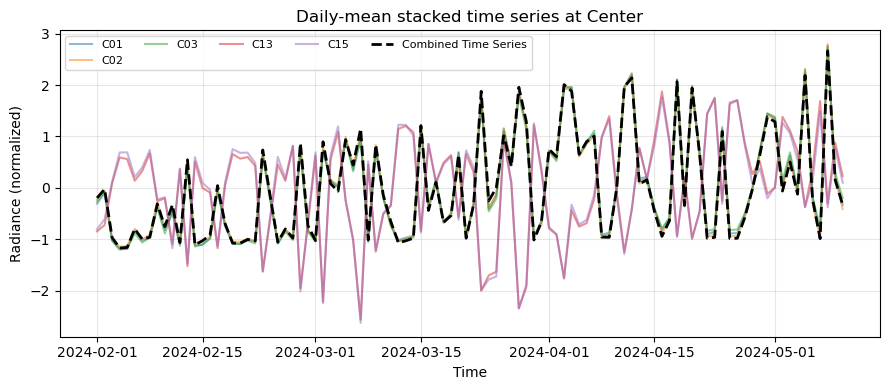

In [12]:
# Collapse stack to daily means:
X_day, day_times, counts_day = daily_average_stack(X, times, min_per_day=3, full_range=True)
print("Daily stack:", X_day.shape, "days:", len(day_times))

# Plot the center pixel’s daily time series:
plot_stacked_time_series(X_day, times=day_times, row=X_day.shape[2]//2, col=X_day.shape[3]//2,band_labels=bands, show_pca=True, normalize=True,title="Daily-mean stacked time series at Center")

In [13]:
#Compress the daily time series window like before
def compress_daily_windows(X_day, day_times,window_days=30,stride_days=None,p=0.5,seed=42,store_forward_as="avg",):

    assert X_day.ndim == 4, 
    D, B, H, W = X_day.shape
    day_times = pd.to_datetime(day_times)

    # ensure fully daily range and pad missing days with NaNs
    full_days = pd.date_range(day_times.min().normalize(),day_times.max().normalize(), freq="D")
    if len(full_days) != D:
        Xr = np.full((len(full_days), B, H, W), np.nan, dtype=X_day.dtype)
        idx = pd.Index(full_days).get_indexer(day_times)
        Xr[idx[idx >= 0]] = X_day
        X_day = Xr
        day_times = full_days
        D = len(full_days)

    if stride_days is None:
        stride_days = window_days

    rng = np.random.default_rng(seed)

    compressed, counts = [], []
    masks, blocks = [], []
    block_times = []
    target_times_per_block = []

    # iterate windows by day index
    start = 0
    n_iters = max(0, (D - window_days) // stride_days + (1 if D >= window_days else 0))
    with tqdm(total=n_iters, desc="Compressing daily windows") as pbar:
        while start + window_days <= D:
            stop = start + window_days

            blk_days = day_times[start:stop]         
            blk      = X_day[start:stop]            
            n_t      = blk.shape[0]

            #Mask per band making sure every pixel is covered at least once 
            blk_BtHW = blk.transpose(1,0,2,3)        
            avail    = np.isfinite(blk_BtHW)         

            # Bernoulli masks
            m = ((rng.random(blk_BtHW.shape) < p) & avail).astype(np.uint8)

            # guarantee ≥1 sample per pixel if there is an available frame
            miss = (m.sum(axis=1) == 0) & (avail.any(axis=1)) 
            if miss.any():
                t_mid = n_t // 2
                dist = np.abs(np.arange(n_t)[None, :, None, None] - t_mid)    
                dist_masked = np.where(avail, dist, np.inf)                  
                t_idx = dist_masked.argmin(axis=1).astype(np.int32)
                b_idx, h_idx, w_idx = np.where(miss)
                t_pick = t_idx[b_idx, h_idx, w_idx]
                m[b_idx, t_pick, h_idx, w_idx] = 1

            # forward projection
            m_f   = m.astype(np.float32)
            y_sum = np.nansum(blk_BtHW * m_f, axis=1).astype(np.float32) 
            cnt   = m.sum(axis=1, dtype=np.uint16)
            
            if store_forward_as == "avg":
                y = y_sum / np.maximum(cnt.astype(np.float32), 1e-8)
                y[cnt == 0] = np.nan
            elif store_forward_as == "sum":
                y = y_sum
            else:
                raise ValueError("store_forward_as must be 'avg' or 'sum'")

            compressed.append(y.astype(np.float32))
            counts.append(cnt)
            masks.append(m)                                   
            blocks.append(blk_BtHW.astype(np.float32))
            block_times.append(blk_days[0] + pd.Timedelta(days=window_days/2))
            target_times_per_block.append(list(blk_days.to_pydatetime()))

            start += stride_days
            pbar.update(1)

    out = {"compressed": np.stack(compressed, axis=0) if compressed else np.empty((0,B,H,W), dtype=np.float32),
        "counts": np.stack(counts, axis=0) if counts else np.empty((0,B,H,W), dtype=np.uint16),
        "masks":masks,"blocks": blocks,"block_times": block_times,"target_times_per_block": target_times_per_block,}
    return out

# save blocks as npz files
def save_compressed_daily_blocks(comp,out_dir,location,band_ids,save_masks=True,save_blocks=True,save_counts=True):

    os.makedirs(out_dir, exist_ok=True)
    Wn = comp["compressed"].shape[0]

    # fixed unicode to avoid object dtype
    band_ids_arr = np.array([str(b) for b in band_ids], dtype="U16")

    for k in range(Wn):
        y   = np.asarray(comp["compressed"][k], dtype=np.float32) 
        cnt = None
        if "counts" in comp and save_counts:
            cnt = np.asarray(comp["counts"][k], dtype=np.uint16)

        payload = {"compressed": y,"band_ids":   band_ids_arr, "block_time": str(comp["block_times"][k]),"target_times": np.asarray(comp["target_times_per_block"][k], dtype="datetime64[ns]"),}
        if cnt is not None:
            payload["counts"] = cnt

        if save_masks and ("masks" in comp):
            phi = np.asarray(comp["masks"][k])
            # ensure uint8 {0,1}
            payload["masks"] = (phi > 0).astype(np.uint8, copy=False)  # (B,T,H,W)

        if save_blocks and ("blocks" in comp):
            Xb = np.asarray(comp["blocks"][k], dtype=np.float32)       # (B,T,H,W)
            payload["blocks"] = Xb

        out_fp = os.path.join(out_dir, f"{location}_block_{k:03d}.npz")
        np.savez_compressed(out_fp, **payload)

    print(f"Saved {Wn} compressed daily blocks for {location} → {out_dir}")
    return out_dir

In [14]:
#Plot the compressed time series function
def plot_compressed_block_series(comp,   band_ids=None,row=None, col=None,box=None,normalize=True,show_pca=True,title=None):
    
    Xc = comp["compressed"] 
    times = comp.get("block_times", np.arange(Xc.shape[0]))
    Wn, B, H, W = Xc.shape

    # choose spatial reducer
    if box is not None:
        y0,y1,x0,x1 = box
        reducer = lambda A: np.nanmean(A[..., y0:y1, x0:x1], axis=(-1,-2)) 
        loc_label = f"mean box y[{y0}:{y1}], x[{x0}:{x1}]"
    else:
        if row is None: row = H//2
        if col is None: col = W//2
        reducer = lambda A: A[..., row, col]
        loc_label = f"pixel (row={row}, col={col})"

    Y = reducer(Xc)  # (Wn,B)

    #normalization for better overlay
    Yp = Y.astype(float).copy()
    if normalize:
        for b in range(B):
            mu = np.nanmean(Yp[:, b])
            sd = np.nanstd(Yp[:, b]) + 1e-8
            Yp[:, b] = (Yp[:, b] - mu) / sd

    # plot per-band series
    plt.figure(figsize=(10,4))
    for b in range(B):
        lbl = band_ids[b] if (band_ids and b < len(band_ids)) else f"Band {b+1}"
        plt.plot(times, Yp[:, b], lw=1.6, label=lbl, alpha = 0.5)

    # PCA-1 across bands over time
    if show_pca:
        Yc = Y - np.nanmean(Y, axis=0, keepdims=True)
        Yc = np.nan_to_num(Yc, nan=0.0)
        U,S,Vt = np.linalg.svd(Yc, full_matrices=False)
        pc1 = U[:,0] * S[0]
        pc1 = pc1 / (np.std(pc1) + 1e-8)
        plt.plot(times, pc1, "k--", lw=2, label="Combined Time Series")

    plt.grid(True, alpha=0.3)
    plt.xlabel("Time")
    plt.ylabel("Radiance (Normalized)" if normalize else "Value")
    plt.title(title or f"Compressed-block time series at Center")
    plt.legend(ncol=min(B+1, 5), fontsize=8)
    plt.tight_layout()
    plt.show()

# Plot the counts to see count distribution
def plot_compressed_counts_series(comp, band_ids=None, row=None, col=None, box=None, title=None):

    C = comp["counts"]  
    times = comp.get("block_times", np.arange(C.shape[0]))
    Wn, B, H, W = C.shape

    if box is not None:
        y0,y1,x0,x1 = box
        reducer = lambda A: np.nanmean(A[..., y0:y1, x0:x1], axis=(-1,-2))
        loc_label = f"mean box y[{y0}:{y1}], x[{x0}:{x1}]"
    else:
        if row is None: row = H//2
        if col is None: col = W//2
        reducer = lambda A: A[..., row, col]
        loc_label = f"pixel (row={row}, col={col})"

    Y = reducer(C)  # (Wn,B)

    plt.figure(figsize=(10,3.6))
    for b in range(B):
        lbl = band_ids[b] if (band_ids and b < len(band_ids)) else f"Band {b+1}"
        plt.step(times, Y[:, b], where="mid", lw=1.5, label=lbl)
    plt.grid(True, alpha=0.3)
    plt.xlabel("Time")
    plt.ylabel("Sample count")
    plt.title(title or f"Compressed-block sample counts at Center")
    plt.legend(ncol=min(B, 5), fontsize=8)
    plt.tight_layout()
    plt.show()

In [15]:
# Compress by 7-day windows (no overlap)
#EXAMPLE: BOSTON
output_directory = 'compressed monthly bos'
locations = 'bos'

comp_day = compress_daily_windows(X_day, day_times,window_days=30,stride_days=1,p=0.5, seed=42)

print("Blocks:", comp_day["compressed"].shape[0], "shape per frame:", comp_day["compressed"].shape[2:])

#Check frames per block (will all be n_t = window_days)
print("Frames per block:", [len(ts) for ts in comp_day["target_times_per_block"]])

# Save to disk
out_dir = save_compressed_daily_blocks(comp_day, output_directory, location=locations, band_ids=band_ids)


Compressing daily windows: 100%|███████████████| 71/71 [00:00<00:00, 277.90it/s]


Blocks: 71 shape per frame: (50, 50)


Rendering frames: 100%|██████████████████████| 71/71 [00:00<00:00, 15987.31it/s]


Saved animation with 71 frames to daily_compressed_pca.gif
Frames per block: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
Saved 71 compressed daily blocks for bos → compressed monthly bos


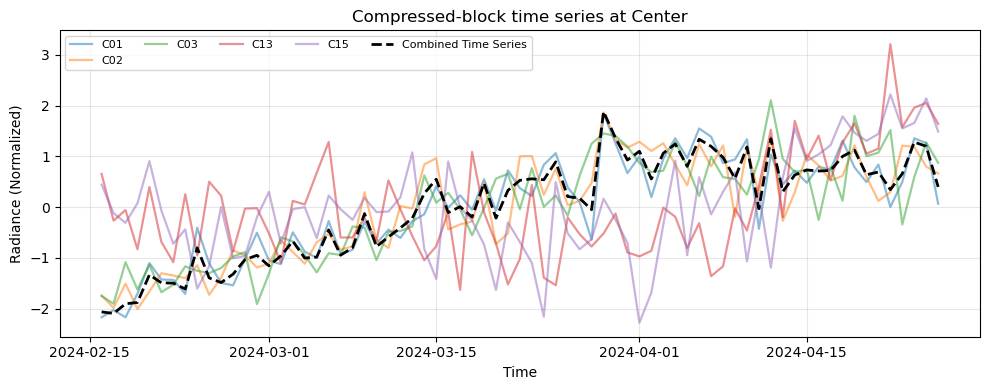

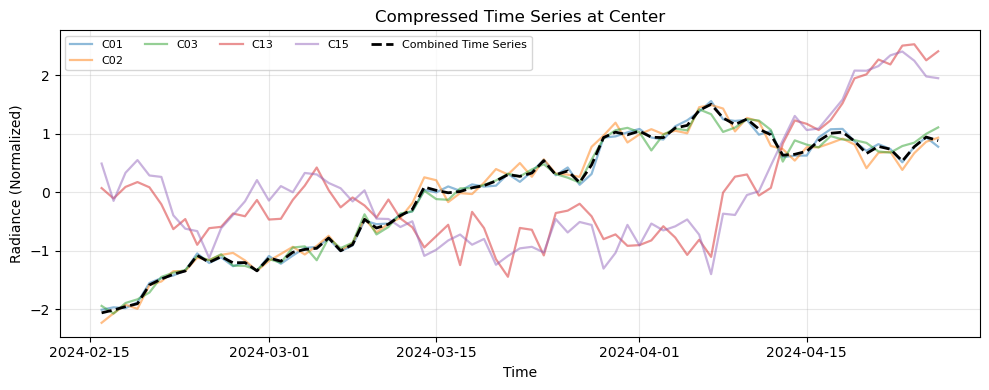

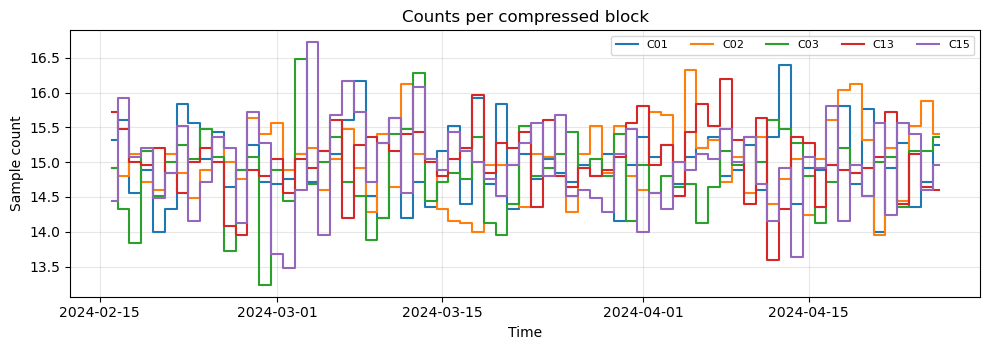

In [16]:
#PLOTTING


plot_compressed_block_series(comp_day, band_ids=bands, show_pca=True, normalize=True)

#Regional mean over a 5×5 box around the center
H, W = comp_day["compressed"].shape[2:]
plot_compressed_block_series(comp_day, band_ids=bands,box=(H//2-2, H//2+3, W//2-2, W//2+3),show_pca=True, normalize=True,title="Compressed Time Series at Center")

#Counter Plot
plot_compressed_counts_series(comp_day, band_ids=bands,box=(H//2-2, H//2+3, W//2-2, W//2+3),title="Counts per compressed block")

In [17]:
#Make a loop for compressions
def run_daily_compression_for_locations(base_path: str,locations: list[str],band_ids: list[str],out_dir: str,daily_min_per_day: int = 1,daily_full_range: bool = True,window_days: int = 7,stride_days: int | None = None,p: float = 0.5,seed: int = 42,save_masks: bool = True,save_blocks: bool = True,tolerance: str = "10s",timeline_strategy: str = "union",target_grid: str = "coarsest",resize_order: int = 1):

    os.makedirs(out_dir, exist_ok=True)
    summaries = []

    for loc in locations:
        print(f"\n=== {loc} ===")
        loc_in = os.path.join(base_path, f"time_series_cleaned_{loc}")
        if not os.path.isdir(loc_in):
            print(f"[{loc}] missing folder: {loc_in}")
            summaries.append((loc, 0, 0, 0))
            continue

        try:
            X, times, bands = load_align_resample_bands(folder=loc_in,band_ids=band_ids,tolerance=tolerance,timeline_strategy=timeline_strategy,target_grid=target_grid,resize_order=resize_order)
            X, times = coalesce_duplicate_timestamps_xr(X, times, how="mean")
        except Exception as e:
            print(f"[{loc}] load/align failed: {e}")
            summaries.append((loc, 0, 0, 0))
            continue

        T = X.shape[0]
        if T == 0:
            print(f"[{loc}] no frames after alignment")
            summaries.append((loc, 0, 0, 0))
            continue
        print(f"[{loc}] frames loaded: {T}")

        # Daily average
        X_day, day_times, counts_day = daily_average_stack(X, times, min_per_day=daily_min_per_day, full_range=daily_full_range)
        D = X_day.shape[0]
        print(f"[{loc}] daily frames: {D}")

        if D == 0:
            summaries.append((loc, T, 0, 0))
            continue

        # Compress into windows
        comp = compress_daily_windows(X_day, day_times,window_days=window_days,stride_days=stride_days,p=p,seed=seed )
        Wn = comp["compressed"].shape[0]
        print(f"[{loc}] compressed blocks: {Wn}")

        # Save all blocks into the *shared* out_dir
        for k in range(Wn):
            payload = { "compressed": comp["compressed"][k],"counts": comp["counts"][k], "band_ids": np.array(bands, dtype=object),"location": loc,"block_time": str(comp["block_times"][k]),"target_times": np.array(comp["target_times_per_block"][k], dtype="datetime64[ns]")}
            if save_masks:
                payload["masks"] = comp["masks"][k]
            if save_blocks:
                payload["blocks"] = comp["blocks"][k]

            fname = f"{loc}_block_{k:03d}.npz"
            np.savez_compressed(os.path.join(out_dir, fname), **payload)

        summaries.append((loc, T, D, Wn))
        print(f"[{loc}] saved {Wn} blocks into {out_dir}")

    return summaries

In [18]:
# Compress
locations = ['losangeles']
band_ids  = ["C01","C02","C03","C13","C15"]

summ = run_daily_compression_for_locations(
    base_path=".", 
    locations=locations,
    band_ids=band_ids,
    out_dir="multiband_compressed_blocks_30days",
    daily_min_per_day=3,
    daily_full_range=True,
    window_days=30,
    stride_days=1,
    p=0.5,
    seed=42,
    save_masks=True,
    save_blocks=True
)

print("\nSummary (loc, frames_in, days, blocks):")




=== losangeles ===
Loading bands...


Loading: 100%|████████████████████████████████████| 5/5 [00:16<00:00,  3.29s/it]


Target grid: C13 → (50, 50)
Resampling to common grid...


Resampling:   0%|                                         | 0/5 [00:00<?, ?it/s]/var/folders/sz/vyxqp2d96dd_9nf4jdvs29800000gn/T/ipykernel_12576/730099979.py:55: RuntimeWarning: Mean of empty slice
  agg_frames = [np.nanmean(frames[inds], axis=0) for inds in groups]
Resampling:  20%|██████▌                          | 1/5 [00:03<00:13,  3.30s/it]/var/folders/sz/vyxqp2d96dd_9nf4jdvs29800000gn/T/ipykernel_12576/730099979.py:55: RuntimeWarning: Mean of empty slice
  agg_frames = [np.nanmean(frames[inds], axis=0) for inds in groups]
Resampling:  40%|█████████████▏                   | 2/5 [00:08<00:13,  4.58s/it]/var/folders/sz/vyxqp2d96dd_9nf4jdvs29800000gn/T/ipykernel_12576/730099979.py:55: RuntimeWarning: Mean of empty slice
  agg_frames = [np.nanmean(frames[inds], axis=0) for inds in groups]
Resampling:  60%|███████████████████▊             | 3/5 [00:11<00:07,  3.84s/it]/var/folders/sz/vyxqp2d96dd_9nf4jdvs29800000gn/T/ipykernel_12576/730099979.py:55: RuntimeWarning: Mean of empty slice
 

Aligning timelines...


Aligning: 100%|███████████████████████████████████| 5/5 [00:00<00:00, 29.83it/s]


[losangeles] frames loaded: 14312
[losangeles] daily frames: 100


Compressing daily windows: 100%|███████████████| 71/71 [00:00<00:00, 348.53it/s]


[losangeles] compressed blocks: 71
[losangeles] saved 71 blocks into multiband_compressed_blocks_

Summary (loc, frames_in, days, blocks):
